In [2]:
# Import wszystkich potrzebnych bibliotek

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Markdown
import geopy
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import requests
import time
from sqlalchemy import create_engine, text
from simpledbf import Dbf5
from sqlalchemy.exc import SQLAlchemyError
import pymysql
from pyproj import Transformer
from geopy.geocoders import Nominatim
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import wilcoxon


PyTables is not installed. No support for HDF output.


In [ ]:
# Dane do połączenia z bazą danych MySQL
username = "gis_user"
password = "XXX" # Usunąłem własne hasło ze względów bezpieczeństwa - odtwarzając trzeba ustanowić własne wewnątrz MySQL Workbench
host = "localhost"
database = "gis_db"

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")

queries = [
    "DROP TABLE IF EXISTS gis_attributes;",
    """
    CREATE TABLE gis_attributes (
        OBJECTID_1 INT,
        GEOCODE VARCHAR(10),
        PARCELID VARCHAR(12),
        DIGITAL_AC DECIMAL(19, 8),
        AlternateI VARCHAR(15),
        TaxYear INT,
        PropertyCl VARCHAR(10),
        SubClass VARCHAR(100),
        DistrictsA VARCHAR(254),
        TifDistric VARCHAR(254),
        OwnerName VARCHAR(254),
        MailOwnerN VARCHAR(250),
        MailLine1 VARCHAR(100),
        MailLine2 VARCHAR(100),
        MailCity VARCHAR(100),
        MailState VARCHAR(10),
        MailPostal VARCHAR(25),
        FullSitus VARCHAR(100),
        SitusCityN VARCHAR(50),
        SitusState VARCHAR(5),
        SitusPosta VARCHAR(25),
        Legal VARCHAR(254),
        SecTwpRang VARCHAR(25),
        DeededAcre DECIMAL(19, 3),
        FullAcres DECIMAL(19, 3),
        ExemptAcre DECIMAL(19, 3),
        NetAcres DECIMAL(19, 3),
        DeededBook VARCHAR(10),
        DeededPage VARCHAR(10),
        DeededDate DATE,
        DeededInst VARCHAR(10),
        ContractBo VARCHAR(10),
        ContractPa VARCHAR(10),
        ContractDa DATE,
        ContractIn VARCHAR(10),
        YearParcel VARCHAR(5),
        ExemptLand DECIMAL(18, 0),
        ExemptBuil DECIMAL(18, 0),
        ExemptDwel DECIMAL(18, 0),
        FullLandVa DECIMAL(18, 0),
        FullBuildi DECIMAL(18, 0),
        FullDwelli DECIMAL(18, 0),
        FullTotalV DECIMAL(18, 0),
        FullUnitCo DECIMAL(18, 0),
        FullBuil_1 INT,
        FullDwel_1 INT,
        AssessedLa DECIMAL(18, 0),
        AssessedBu DECIMAL(18, 0),
        AssessedDw DECIMAL(18, 0),
        AssessedTo DECIMAL(18, 0),
        AssessedUn DECIMAL(18, 0),
        Assessed_1 INT,
        Assessed_2 INT,
        TaxableLan DECIMAL(18, 0),
        TaxableBui DECIMAL(18, 0),
        TaxableDwe DECIMAL(18, 0),
        TaxableTot DECIMAL(18, 0),
        GrossTaxes DECIMAL(18, 0),
        NetTaxes DECIMAL(18, 0),
        Military INT,
        Homestead INT,
        HomesteadT DECIMAL(18, 0),
        FamilyFarm INT,
        FamilyFa_1 DECIMAL(18, 0),
        AgLand INT,
        AglandTax DECIMAL(18, 0),
        DSCTax DECIMAL(18, 0),
        DrainageTa DECIMAL(18, 0),
        ExemptCSR DECIMAL(18, 0),
        ExemptCSRP DECIMAL(18, 0),
        CSRPoints DECIMAL(18, 0),
        CSRPointsP DECIMAL(18, 0)
    );
    """,
    "DROP TABLE IF EXISTS gis_geom;",
    """
    CREATE TABLE gis_geom (
        id INT AUTO_INCREMENT PRIMARY KEY,
        parcel_id VARCHAR(12) NOT NULL,
        geom GEOMETRY NOT NULL,
        centroid POINT NOT NULL,
        SPATIAL INDEX geom_index (geom),
        SPATIAL INDEX centroid_index (centroid)
    ) ENGINE=InnoDB;
    """,
    "DROP TABLE IF EXISTS model_data;",
    """
    CREATE TABLE model_data (
        order_id INT PRIMARY KEY AUTO_INCREMENT,
        PID VARCHAR(10) NOT NULL,
        MS_SubClass VARCHAR(10),
        MS_Zoning VARCHAR(20),
        Lot_Frontage INT,
        Lot_Area INT,
        Street VARCHAR(20),
        Alley VARCHAR(20),
        Lot_Shape VARCHAR(10),
        Land_Contour VARCHAR(10),
        Utilities VARCHAR(30),
        Lot_Config VARCHAR(20),
        Land_Slope VARCHAR(10),
        Neighborhood VARCHAR(30),
        Condition_1 VARCHAR(20),
        Condition_2 VARCHAR(20),
        Bldg_Type VARCHAR(20),
        House_Style VARCHAR(20),
        Overall_Qual INT,
        Overall_Cond INT,
        Year_Built INT,
        Year_Remod_Add INT,
        Roof_Style VARCHAR(20),
        Roof_Matl VARCHAR(20),
        Exterior_1st VARCHAR(30),
        Exterior_2nd VARCHAR(30),
        Mas_Vnr_Type VARCHAR(20),
        Mas_Vnr_Area INT,
        Exter_Qual VARCHAR(10),
        Exter_Cond VARCHAR(10),
        Foundation VARCHAR(20),
        Bsmt_Qual VARCHAR(10),
        Bsmt_Cond VARCHAR(10),
        Bsmt_Exposure VARCHAR(10),
        BsmtFin_Type_1 VARCHAR(20),
        BsmtFin_SF_1 INT,
        BsmtFin_Type_2 VARCHAR(20),
        BsmtFin_SF_2 INT,
        Bsmt_Unf_SF INT,
        Total_Bsmt_SF INT,
        Heating VARCHAR(20),
        Heating_QC VARCHAR(10),
        Central_Air CHAR(1),
        Electrical VARCHAR(20),
        First_Flr_SF INT,
        Second_Flr_SF INT,
        Low_Qual_Fin_SF INT,
        Gr_Liv_Area INT,
        Bsmt_Full_Bath INT,
        Bsmt_Half_Bath INT,
        Full_Bath INT,
        Half_Bath INT,
        Bedroom_AbvGr INT,
        Kitchen_AbvGr INT,
        Kitchen_Qual VARCHAR(10),
        TotRms_AbvGrd INT,
        Functional VARCHAR(20),
        Fireplaces INT,
        Fireplace_Qu VARCHAR(10),
        Garage_Type VARCHAR(20),
        Garage_Yr_Blt INT,
        Garage_Finish VARCHAR(20),
        Garage_Cars INT,
        Garage_Area INT,
        Garage_Qual VARCHAR(10),
        Garage_Cond VARCHAR(10),
        Paved_Drive CHAR(1),
        Wood_Deck_SF INT,
        Open_Porch_SF INT,
        Enclosed_Porch INT,
        Three_Ssn_Porch INT,
        Screen_Porch INT,
        Pool_Area INT,
        Pool_QC VARCHAR(10),
        Fence VARCHAR(20),
        Misc_Feature VARCHAR(20),
        Misc_Val INT,
        Mo_Sold INT,
        Yr_Sold INT,
        Sale_Type VARCHAR(20),
        Sale_Condition VARCHAR(20),
        SalePrice INT,
        INDEX idx_PID (PID),
        UNIQUE (PID)
    );
    """
]

# Wykonanie każdego zapytania osobno
with engine.connect() as conn:
    for query in queries:
        try:
            conn.execute(text(query))
            print(f"Wykonano zapytanie: {query[:30]}...")
        except SQLAlchemyError as e:
            print(f"Błąd przy wykonywaniu zapytania SQL: {e}")


In [ ]:
# Kod wczytujący główny plik wykorzystywany przeze mnie do stworzenia modelu predykcyjnego

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")

csv_file_path = "AmesHousing.csv"

# Kolumny tekstowe - krok wymagany, ponieważ część kolumn tekstowych ma na początku 0 i Pandas niepoprawnie je interpretował
text_columns = [
    'PID', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
    'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
    'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',
    'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
    'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu',
    'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence',
    'Misc Feature', 'Sale Type', 'Sale Condition'
]

converters = {col: str for col in text_columns}

df = pd.read_csv(csv_file_path, converters=converters)

# W kolumnach tekstowych NA było niepoprawnie interpretowane jako tekst.
df.replace('NA', np.nan, inplace=True)

# Trzeba zmianić spacje na _ aby poprawnie dodać dane do bazy
df.columns = df.columns.str.replace(' ', '_')

# Szybkie sprawdzenie, czy faktycznie dane tesktowe mają typ Obejct
print(df.dtypes) 

df.columns = [
    "order_id", "PID", "MS_SubClass", "MS_Zoning", "Lot_Frontage", "Lot_Area", "Street", "Alley",
    "Lot_Shape", "Land_Contour", "Utilities", "Lot_Config", "Land_Slope", "Neighborhood",
    "Condition_1", "Condition_2", "Bldg_Type", "House_Style", "Overall_Qual", "Overall_Cond",
    "Year_Built", "Year_Remod_Add", "Roof_Style", "Roof_Matl", "Exterior_1st", "Exterior_2nd",
    "Mas_Vnr_Type", "Mas_Vnr_Area", "Exter_Qual", "Exter_Cond", "Foundation", "Bsmt_Qual", "Bsmt_Cond",
    "Bsmt_Exposure", "BsmtFin_Type_1", "BsmtFin_SF_1", "BsmtFin_Type_2", "BsmtFin_SF_2",
    "Bsmt_Unf_SF", "Total_Bsmt_SF", "Heating", "Heating_QC", "Central_Air", "Electrical",
    "First_Flr_SF", "Second_Flr_SF", "Low_Qual_Fin_SF", "Gr_Liv_Area", "Bsmt_Full_Bath",
    "Bsmt_Half_Bath", "Full_Bath", "Half_Bath", "Bedroom_AbvGr", "Kitchen_AbvGr", "Kitchen_Qual",
    "TotRms_AbvGrd", "Functional", "Fireplaces", "Fireplace_Qu", "Garage_Type", "Garage_Yr_Blt",
    "Garage_Finish", "Garage_Cars", "Garage_Area", "Garage_Qual", "Garage_Cond", "Paved_Drive",
    "Wood_Deck_SF", "Open_Porch_SF", "Enclosed_Porch", "Three_Ssn_Porch", "Screen_Porch",
    "Pool_Area", "Pool_QC", "Fence", "Misc_Feature", "Misc_Val", "Mo_Sold", "Yr_Sold",
    "Sale_Type", "Sale_Condition", "SalePrice"
]

try:
    df.to_sql('model_data', con=engine, if_exists='append', index=False, method='multi')
    print("Dane wykorzystywane do tworzenia modelu predykcyjnego zostały pomyślnie zaimportowane do bazy danych.")
except Exception as e:
    print(f"Wystąpił błąd podczas importu danych: {e}")

# Kod wczytujący atrybuty dla parceli - z pliku bazodanowaego (.dbf) zaimportowanego ze strony https://www.iowagisdata.org

dbf = Dbf5('Parcels - Database/Parcels.dbf')
df = dbf.to_dataframe()

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")

df.to_sql('gis_attributes', con=engine, if_exists='append', index=False)

print("Dane dotyczące atrybutów GIS dla parceli zostały pomyślnie zaimportowane do bazy danych.")


# kod wczytujący dane przestrzenne parceli - z pliku (.shp) zaimportowanego ze strony https://www.iowagisdata.org

shapefile_path = "Parcels - Database/Parcels.shp"
gdf = gpd.read_file(shapefile_path)

gdf.set_crs("EPSG:3417", allow_override=True, inplace=True)

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")

with engine.connect() as conn:
    
    trans = conn.begin()
    
    try:
        for _, row in gdf.iterrows():
            # Parcel ID
            parcel_id = row['PARCELID']

            geom_wkt = row['geometry'].wkt

            insert_sql = text("""
                INSERT INTO gis_geom (parcel_id, geom, centroid)
                VALUES (:parcel_id, ST_GeomFromText(:geom_wkt, 3417), ST_Centroid(ST_GeomFromText(:geom_wkt, 3417)))
            """)

            conn.execute(insert_sql, {'parcel_id': parcel_id, 'geom_wkt': geom_wkt})
        
        trans.commit()
        
    except SQLAlchemyError as e:
        
        trans.rollback()
        print(f"Błąd przy wstawianiu rekordu: {e}")

print("Dane przestrzenne parceli GIS zostały pomyślnie zaimportowane do bazy danych.")

# Tworzymy plik CSV/XLSX/JSON na potrzeby przeprowadzenia takiej samej analizy - plik będzie załączony

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")

query = """
SELECT
    model_data.*,
    ST_X(gis_geom.centroid) AS longitude,  -- Praca w EPSG:3417
    ST_Y(gis_geom.centroid) AS latitude,   -- Praca w EPSG:3417
    gis_attributes.FullSitus AS address
FROM
    model_data
LEFT JOIN gis_geom ON model_data.PID = gis_geom.parcel_id
LEFT JOIN gis_attributes ON model_data.PID = gis_attributes.PARCELID
ORDER BY model_data.order_id;
"""

try:
    
    df = pd.read_sql(query, engine)
    print("Dane zostały pomyślnie załadowane do DataFrame.")

    # Eksportowanie wyników do pliku CSV
    df.to_csv('ExportMySQL_AmesHousing.csv', index=False)
    print("Dane zostały pomyślnie zapisane do pliku 'ExportMySQL_AmesHousing.csv'.")

    # Możnaby też eksportować do innych źródeł, jakbym dalej potrzebował:
    # df.to_excel('output_data.xlsx', index=False)
    # df.to_json('output_data.json', orient='records')

except SQLAlchemyError as e:
    print(f"Błąd przy wykonaniu zapytania: {e}")



In [ ]:
def missing_data_summary(df):

    total_records = len(df) 
    
    # Tworzenie DataFrame z informacjami o brakujących danych
    summary = pd.DataFrame({
        "Variable Name": df.columns,
        "Total Records": total_records,
        "Missing Count": df.isna().sum(),
        "Missing Percentage %": (df.isna().sum() / total_records) * 100,
        "Missing in Column": ["Yes" if count > 0 else "No" for count in df.isna().sum()]
    })
    
    summary = summary[["Variable Name", "Total Records", "Missing Count", "Missing Percentage %", "Missing in Column"]]
    summary["Missing Percentage %"] = summary["Missing Percentage %"].round(2)
    
    return summary

missing_summary = missing_data_summary(train_data)

missing_summary[missing_summary["Missing Percentage %"] > 10].sort_values(by = "Missing Percentage %", ascending = False)

missing_summary[missing_summary["Missing Percentage %"] > 1].sort_values(by = "Missing Percentage %", ascending = False)

missing_summary[missing_summary["Missing in Column"] == "Yes"].sort_values(by = "Missing Percentage %", ascending = False)

In [ ]:
# Wczytanie danych z pliku CSV bez konwersji pustych ciągów na NaN
df = pd.read_csv('ExportMySQL_AmesHousing.csv', keep_default_na=False, engine='python')

print(df.shape)

# Lista kolumn kategorii, NA oznacza brak cechy (uzupełniam 'None')!!
qual_none_cols = [
    'Pool_QC', 'Alley', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
    'BsmtFin_Type_1', 'BsmtFin_Type_2', 'Fireplace_Qu', 'Garage_Type',
    'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Fence', 'Misc_Feature',
    'Mas_Vnr_Type'
]
# Zastąpienia: 'NA' lub pusty ciąg 'None'
df[qual_none_cols] = df[qual_none_cols].replace({'NA': 'None', '': 'None'})

# Lista kolumn liczbowych, gdzie brak oznacza brak cechy (uzupełnienie 0)
num_zero_cols = ['Mas_Vnr_Area', 'Garage_Yr_Blt']
# Zastąpienia: 'NA' lub pusty ciąg -> '0'
df[num_zero_cols] = df[num_zero_cols].replace({'NA': '0', '': '0'})
# Konwersja tych kolumn na typ numeryczny (float)
df['Mas_Vnr_Area'] = df['Mas_Vnr_Area'].astype(float)
df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].astype(float)

# Uzupełnienie zmiennych, gdzie brak to rzeczywisty brak danych, modą
if (df['Electrical'] == '').any():
    most_freq = df.loc[df['Electrical'] != '', 'Electrical'].mode()[0]  
    df['Electrical'] = df['Electrical'].replace({'': most_freq})

# Uzupełnienie Lot_Frontage medianą dla dzielnicy
df['Lot_Frontage'] = df['Lot_Frontage'].replace({'': np.nan}).astype(float)
df['Lot_Frontage'] = df.groupby('Neighborhood')['Lot_Frontage'] \
                       .transform(lambda x: x.fillna(x.median()))
# Jeśli w niektórych dzielnicach brak w ogóle wartości (np. same braki w dzielnicy - była jedna taka dzielnica), uzupełniłem medianą wszystkich obserwacji
df['Lot_Frontage'].fillna(df['Lot_Frontage'].median(), inplace=True)

# Poprawa nazwy kolumny 'lattitude' -> 'latitude', bo oczywiście zrobiłem literówkę w zapisywaniu
df.rename(columns={'lattitude': 'latitude'}, inplace=True)

# Konwersja kolumn latitude i longitude na typ numeryczny (oznaczenie braków jako NaN)
df['longitude'] = df['longitude'].replace({'': np.nan}).astype(float)
df['latitude']  = df['latitude'].replace({'': np.nan}).astype(float)

df['longitude'] = df.groupby('Neighborhood')['longitude'] \
                       .transform(lambda x: x.fillna(x.median()))

df['longitude'].fillna(df['longitude'].median(), inplace=True)

df['latitude'] = df.groupby('Neighborhood')['latitude'] \
                       .transform(lambda x: x.fillna(x.median()))

df['latitude'].fillna(df['latitude'].median(), inplace=True)

# Ustawienie współrzędnych centrum Ames w układzie EPSG:3417 (ft)
center_x_3417 = 4889528.75  # długość geograficzna w EPSG:3417
center_y_3417 = 3471344.62  # szerokość geograficzna w EPSG:3417

# Transformacja EPSG:3417 -> EPSG:4326 (stopnie geograficzne) dla centrum Ames
transformer = Transformer.from_crs("EPSG:3417", "EPSG:4326", always_xy=True)
center_lon, center_lat = transformer.transform(center_x_3417, center_y_3417)

df['longitude_4326'], df['latitude_4326'] = transformer.transform(df['longitude'].values, df['latitude'].values)

# Obliczanie odległości Haversine w metrach między każdym punktem a centrum Ames
lat1 = np.radians(df['latitude_4326'])
lon1 = np.radians(df['longitude_4326'])
lat2 = np.radians(center_lat)
lon2 = np.radians(center_lon)

dlat = lat2 - lat1
dlon = lon2 - lon1

# Harvestine odgległość
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))
earth_radius_m = 6371000  # Promień Ziemi w metrach
distance_m = earth_radius_m * c

# Konwersja odległości z metrów na stopy
distance_ft = distance_m * 3.28084

df['Dist_from_Center_ft'] = distance_ft

df.drop(['longitude_4326', 'latitude_4326'], axis=1, inplace=True)


df['Dist_from_Center_ft'] = df.groupby('Neighborhood')['Dist_from_Center_ft'] \
                               .transform(lambda x: x.fillna(x.median()))
df['Dist_from_Center_ft'].fillna(df['Dist_from_Center_ft'].median(), inplace=True)


df.drop(['longitude', 'latitude'], axis=1, inplace=True)

# Usuwanie outlieów (3) póki co
outliers_index = df[(df['Gr_Liv_Area'].astype(float) > 4000) & 
                    (df['SalePrice'].astype(float) < 300000)].index
df.drop(outliers_index, inplace=True)


df.drop_duplicates(inplace=True) # brak duplikatów


if df['SalePrice'].dtype == object:

    df = df[df['SalePrice'] != '']
else:

    df = df[df['SalePrice'].notna()]

# Usunięcie zbędnych spacji na początku i końcu 
obj_columns = df.select_dtypes(include='object').columns
for col in obj_columns:
    df[col] = df[col].str.strip()

# Poprawa literówek
df['Garage_Type'] = df['Garage_Type'].replace({'Basment': 'Basement'})

# Zamiana błędnego roku 2207 na 2007, opisane w pracy
df.loc[df['Garage_Yr_Blt'] == 2207, 'Garage_Yr_Blt'] = 2007


no_bsmt_idx = df[df['Bsmt_Qual'] == 'None'].index
bsmt_num_cols = ['BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF',
                 'Total_Bsmt_SF', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath']
df.loc[no_bsmt_idx, bsmt_num_cols] = 0

no_garage_idx = df[df['Garage_Type'] == 'None'].index
garage_num_cols = ['Garage_Cars', 'Garage_Area', 'Garage_Yr_Blt']
df.loc[no_garage_idx, garage_num_cols] = 0


mask_gar = (df['Garage_Type'] != 'None') & ((df['Garage_Cars'] == '') | (df['Garage_Cars'].isna()))
if mask_gar.any():
    df.loc[mask_gar, 'Garage_Type'] = 'None'
    df.loc[mask_gar, ['Garage_Finish', 'Garage_Qual', 'Garage_Cond']] = 'None'
    df.loc[mask_gar, garage_num_cols] = 0

mask_bsmt = (df['Bsmt_Qual'] != 'None') & (df['BsmtFin_Type_2'] == 'None')
df.loc[mask_bsmt, 'BsmtFin_Type_2'] = 'Unf'

df['MS_SubClass'] = df['MS_SubClass'].astype(str)
df['Mo_Sold'] = df['Mo_Sold'].astype(str)

# Definicje słowników mapujących kategorie porządkowe na wartości liczbowe
qual_map    = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
bsmtexp_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
bsmtfin_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
garagefin_map = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
func_map   = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
paved_map  = {'N': 0, 'P': 1, 'Y': 2}
lotshape_map = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
fence_map = {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

quality_cols = ['Exter_Qual', 'Exter_Cond', 'Bsmt_Qual', 'Bsmt_Cond',
                'Heating_QC', 'Kitchen_Qual', 'Fireplace_Qu',
                'Garage_Qual', 'Garage_Cond', 'Pool_QC']
for col in quality_cols:
    df[col] = df[col].map(qual_map)

# Mapowanie pozostałych kolumn porządkowych
df['Bsmt_Exposure']  = df['Bsmt_Exposure'].map(bsmtexp_map)
df['BsmtFin_Type_1'] = df['BsmtFin_Type_1'].map(bsmtfin_map)
df['BsmtFin_Type_2'] = df['BsmtFin_Type_2'].map(bsmtfin_map)
df['Garage_Finish']  = df['Garage_Finish'].map(garagefin_map)
df['Functional']     = df['Functional'].map(func_map)
df['Paved_Drive']    = df['Paved_Drive'].map(paved_map)
df['Lot_Shape']      = df['Lot_Shape'].map(lotshape_map)
df['Fence']          = df['Fence'].map(fence_map)

df['Sale_Type'] = df['Sale_Type'].str.strip()
df['Exterior_1st'].replace({'BrkComm': 'BrkCmn'}, inplace=True)
df['Exterior_2nd'].replace({'CmentBd': 'CemntBd', 'Brk Cmn': 'BrkCmn'}, inplace=True)


# Usunięcie identyfikatorów
df.drop(['PID', 'order_id'], axis=1, inplace=True)

# Kodowanie centralnej klimatyzacji: 'Y' -> 1, 'N' -> 0
df['Central_Air'] = df['Central_Air'].map({'Y': 1, 'N': 0})


In [ ]:
# Obliczenie logarytmu naturalnego z SalePrice - potem będę budował modele w oparciu o obie wersje
df['SalePrice'] = df['SalePrice'].astype(float) 
df['Log_SalePrice'] = np.log(df['SalePrice'])

In [ ]:
# Przygotowanie dwóch wersji danych do zapisu - jedna SalePrice druga Log_SalePrice
df_clean = df.copy()
df_log   = df.copy()

# W wersji logarytmicznej zmieniam nazwę kolumny celu z SalePrice na Log_SalePrice
df_log.drop('SalePrice', axis=1, inplace=True)
df_clean.drop("Log_SalePrice", axis=1, inplace=True)

df_clean.to_csv('ames_cleaned.csv', index=False)
df_log.to_csv('ames_cleaned_log.csv', index=False)

# W dalszej części pracy będę korystał z tych czystych plików, można de facto zaczynać stąd EDA

In [ ]:
df = pd.read_csv('Ames_Cleaned.csv')  # oczyszczony zbiór danych Ames Housing
# (Plik zawiera 2927 obserwacji i 81 cech, w tym zmienną SalePrice)

folder = "Praca inżynierska Charts"
os.makedirs(folder, exist_ok=True)

# Histogram i KDE dla oryginalnych wartości SalePrice
plt.figure(figsize=(6,4))
sns.histplot(df['SalePrice'], kde=True, color="#00884B", bins=30)
plt.title('Rozkład zmiennej SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Gęstość')
plt.tight_layout()
plt.savefig(os.path.join(folder, "5_2_1_SalePrice.png"), dpi=300, bbox_inches='tight')
plt.show()

# Wczytanie zbioru z przetransformowaną logarytmicznie ceną
df_log = pd.read_csv('Ames_Cleaned_Log.csv') 

# Histogram i KDE dla wartości Log(SalePrice)
plt.figure(figsize=(6,4))
sns.histplot(df_log['Log_SalePrice'], kde=True, color="#00884B", bins=30)
plt.title('Rozkład zmiennej Log(SalePrice)')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Gęstość')
plt.tight_layout()
plt.savefig(os.path.join(folder, "5_2_2_Log_SalePrice.png"), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Wybór cech o najwyższej korelacji bezwzględnej z SalePrice
from matplotlib.colors import LinearSegmentedColormap
corr = df[['SalePrice','Overall_Qual','Gr_Liv_Area','Exter_Qual',
           'Kitchen_Qual','Total_Bsmt_SF','Garage_Cars','First_Flr_SF',
           'Garage_Area','Bsmt_Qual','Year_Built']].corr()

# Maska dla górnej części
mask = np.triu(np.ones_like(corr, dtype=bool))

custom_cmap_div = LinearSegmentedColormap.from_list("green_gray_div",
                                                    ["#AAAAAA", "#FFFFFF", "#00884B"], N=256)
plt.figure(figsize=(8,6))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=custom_cmap_div,
            linewidths=0.5, annot_kws={"size": 9}, cbar_kws={"shrink": 0.8})

plt.title('Korelacje wybranych cech numerycznych (wraz z SalePrice)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(folder, "5_3_CorrelationMatrix.png"), dpi=300, bbox_inches='tight')
plt.show()

# Średnia cena SalePrice w dzielnicach
mean_price_neigh = df.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False)
top15 = mean_price_neigh.head(15).iloc[::-1]  # 15 najwyższych średnich cen

plt.figure(figsize=(10,4))
plt.barh(top15.index, top15.values, color="#00884B")
plt.xlabel('Średnia cena SalePrice (PLN)')
plt.ylabel('Neighborhood')
plt.title('Średnia cena domu w najdroższych dzielnicach Ames')
plt.tight_layout()
plt.savefig(os.path.join(folder, "5_4_SalePriceByNeighborhood.png"), dpi=300, bbox_inches='tight')
plt.show()

# Boxplot SalePrice vs House_Style
plt.figure(figsize=(10,4))
sns.boxplot(x='House_Style', y='SalePrice', data=df, color="#00884B")
plt.title('SalePrice vs House Style')
plt.xlabel('House Style')
plt.ylabel('SalePrice')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(folder, "5_5_SalePriceByHouse_Style.png"), dpi=300, bbox_inches='tight')
plt.show()

# Boxplot SalePrice vs Overall_Qual
plt.figure(figsize=(10,4))
sns.boxplot(x='Overall_Qual', y='SalePrice', data=df, color="#00884B")
plt.title('SalePrice vs OverallQual')
plt.xlabel('Overall Quality (Overall_Qual)')
plt.ylabel('SalePrice')
plt.tight_layout()
plt.savefig(os.path.join(folder, "5_6_SalePriceByOverall_Qual.png"), dpi=300, bbox_inches='tight')
plt.show()

# Boxplot SalePrice vs Garage_Cars
plt.figure(figsize=(10,4))
sns.boxplot(x='Garage_Cars', y='SalePrice', data=df, color="#00884B")
plt.title('SalePrice vs Garage Cars')
plt.xlabel('Number of Garage Cars')
plt.ylabel('SalePrice')
plt.tight_layout()
plt.show()

# Scatterplot SalePrice vs Gr_Liv_Area
plt.figure(figsize=(6,5))
sns.scatterplot(x='Gr_Liv_Area', y='SalePrice', data=df, color="#00884B", alpha=0.6)
plt.title('SalePrice vs Above-grade Living Area')
plt.xlabel('Above-grade living area (sq ft)')
plt.ylabel('SalePrice')
plt.tight_layout()
plt.show() # Brak odatkowych outlierów

In [11]:
df = pd.read_csv('Ames_Cleaned.csv')  # Ames_Cleaned.csv
df_log = pd.read_csv('Ames_Cleaned_Log.csv')  # Ames_Cleaned_Log.csv

# Usunięcie nieprzydatnych kolumn, opisane w pracy dokładnie
irrelevant_cols = [
    "address", "Utilities", "Street", "Condition_2", "Roof_Matl", 
    "Misc_Feature", "Misc_Val", "BsmtFin_SF_1", "BsmtFin_SF_2", 
    "Bsmt_Unf_SF", "First_Flr_SF", "Second_Flr_SF", "Low_Qual_Fin_SF", 
    "Garage_Cars", "Garage_Yr_Blt"
]
df.drop(columns=irrelevant_cols, inplace=True)
df_log.drop(columns=irrelevant_cols, inplace=True)

# Zakodowanie Land_Slope
slope_mapping = {"Sev": 0, "Mod": 1, "Gtl": 2}
df["Land_Slope"] = df["Land_Slope"].map(slope_mapping).astype(int)
df_log["Land_Slope"] = df_log["Land_Slope"].map(slope_mapping).astype(int)

# One-hot encoding cech nominalnych
categorical_cols = [
    "MS_SubClass", "MS_Zoning", "Alley", "Land_Contour", "Lot_Config", 
    "Neighborhood", "Condition_1", "Bldg_Type", "House_Style", "Roof_Style",
    "Exterior_1st", "Exterior_2nd", "Mas_Vnr_Type", "Foundation", 
    "Heating", "Electrical", "Garage_Type", "Sale_Type", "Sale_Condition"
]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_log = pd.get_dummies(df_log, columns=categorical_cols, drop_first=True)

# Inżynieria nowych cech, podrozdział w pracy
def feature_engineering(data):
    data["Total_SF"] = data["Gr_Liv_Area"] + data["Total_Bsmt_SF"]
    data["House_Age"] = data["Yr_Sold"] - data["Year_Built"]
    data["Remod_Age"] = data["Yr_Sold"] - data["Year_Remod_Add"]
    data["Remodeled"] = (data["Year_Remod_Add"] != data["Year_Built"]).astype(int)
    data["Overall_Qual_Cond"] = data["Overall_Qual"] + data["Overall_Cond"]
    data["Living_Lot_Ratio"] = data["Gr_Liv_Area"] / data["Lot_Area"]
    data["Total_Bathrooms"] = (data["Full_Bath"] + 0.5 * data["Half_Bath"] +
                               data["Bsmt_Full_Bath"] + 0.5 * data["Bsmt_Half_Bath"])
    data["Total_Porch_SF"] = (data["Wood_Deck_SF"] + data["Open_Porch_SF"] + 
                              data["Enclosed_Porch"] + data["Three_Ssn_Porch"] + 
                              data["Screen_Porch"])
    return data

df = feature_engineering(df)
df_log = feature_engineering(df_log)

# Usunięcie oryginalnych kolumn zastąpionych przez nowe cechy, tylko te 3 pozostałe zostawaim
cols_to_drop_after_fe = ["Year_Built", "Year_Remod_Add", "Overall_Cond"]
df.drop(columns=cols_to_drop_after_fe, inplace=True)
df_log.drop(columns=cols_to_drop_after_fe, inplace=True)

# Standaryzacja cech numerycznych (bez zmiennych binarnych i celu)
def standardize(df, target_col):
    binary_cols = [col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    cols_to_scale = [col for col in df.columns if col not in binary_cols + [target_col]]
    scaler = StandardScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    return df

df = standardize(df, 'SalePrice')
df_log = standardize(df_log, 'Log_SalePrice')

# Zapis do plików - teraz budowanie modeli
df.to_csv('Ames_Prepared.csv', index=False)
df_log.to_csv('Ames_Prepared_Log.csv', index=False)


In [30]:
df = pd.read_csv("Ames_Prepared.csv")
df_log = pd.read_csv("Ames_Prepared_Log.csv")


X = df.drop(columns=["SalePrice"])
y = df["SalePrice"]
y_log = df_log["Log_SalePrice"]

# Podział na zbiór treningowy (80%) i testowy (20%) z seedem 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [31]:
df["SalePrice"].mean()

180800.7707550393

In [32]:
# Model OLS (oryginalna zmienna SalePrice)
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predykcje na zbiorze treningowym i testowym
y_pred_train = linreg.predict(X_train)
y_pred_test = linreg.predict(X_test)

# Obliczenie metryk R² i RMSE na zbiorze treningowym
r2_train = r2_score(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Obliczenie metryk R² i RMSE na zbiorze testowym
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Wyświetlenie wyników dla zbioru treningowego i testowego
print(f"R² na zbiorze treningowym: {r2_train:.4f}")
print(f"RMSE na zbiorze treningowym: {rmse_train:.4f}")
print(f"R² na zbiorze testowym: {r2_test:.4f}")
print(f"RMSE na zbiorze testowym: {rmse_test:.4f}")

R² na zbiorze treningowym: 0.9253
RMSE na zbiorze treningowym: 21116.3554
R² na zbiorze testowym: -63597950982509272.0000
RMSE na zbiorze testowym: 22639855503843.0664


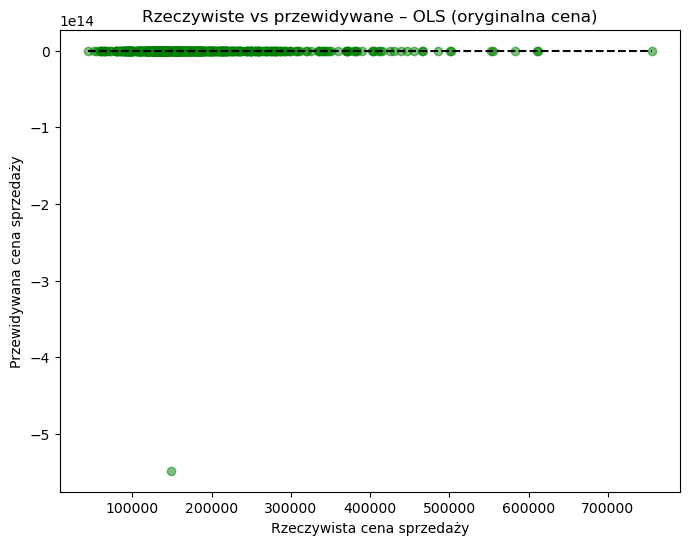

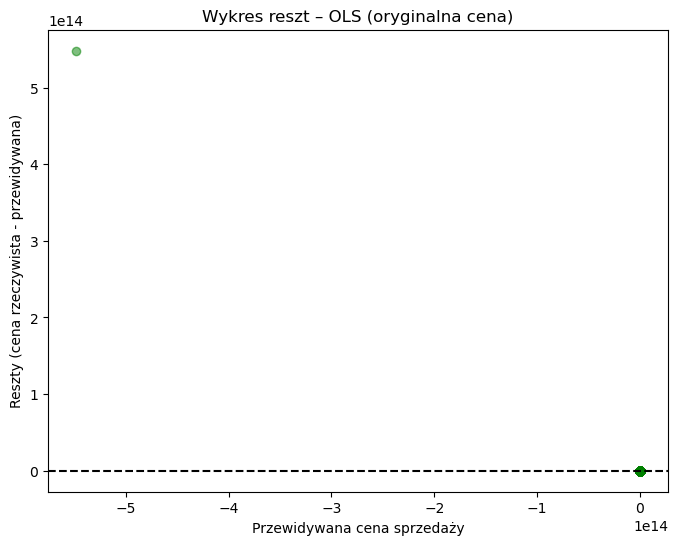

In [33]:
# Wykres 1: Rzeczywiste vs. przewidywane wartości – OLS (oryginalna cena)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
# Linia idealna y=x dla odniesienia
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black')
plt.title('Rzeczywiste vs przewidywane – OLS (oryginalna cena)')
plt.xlabel('Rzeczywista cena sprzedaży')
plt.ylabel('Przewidywana cena sprzedaży')
plt.show()

# Wykres 2: Rozkład reszt – OLS (oryginalna cena)
plt.figure(figsize=(8,6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, color='green', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Wykres reszt – OLS (oryginalna cena)')
plt.xlabel('Przewidywana cena sprzedaży')
plt.ylabel('Reszty (cena rzeczywista - przewidywana)')
plt.show()

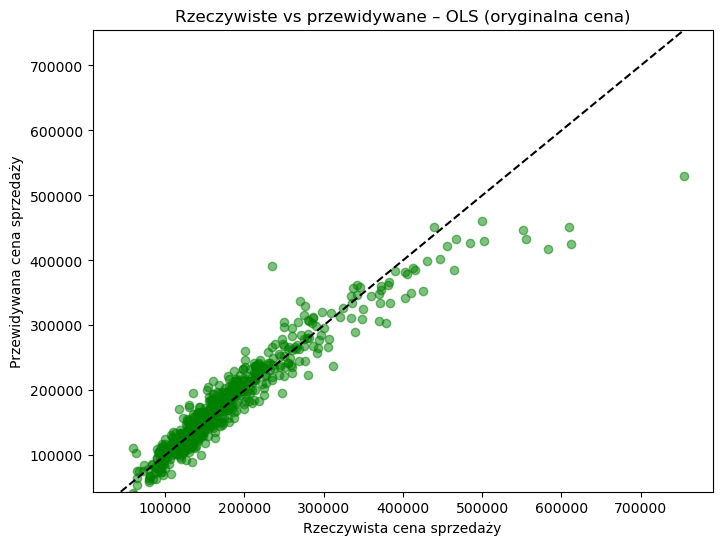

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black')
plt.title('Rzeczywiste vs przewidywane – OLS (oryginalna cena)')
plt.xlabel('Rzeczywista cena sprzedaży')
plt.ylabel('Przewidywana cena sprzedaży')
plt.ylim(y_test.min(), y_test.max())  # lub ręcznie: plt.ylim(0, 800000)
plt.show()

In [21]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Oblicz reszty i ich wartości bezwzględne
residuals = y_test - y_pred_series
abs_residuals = residuals.abs()

# TOP 5 największych błędów
top_n = 5
largest_errors = abs_residuals.sort_values(ascending=False).head(top_n)

# Wyświetlenie informacji
for idx in largest_errors.index:
    print(f"\nIndeks: {idx}")
    print(f"Rzeczywista: {y_test.loc[idx]:,.2f}")
    print(f"Przewidywana: {y_pred_series.loc[idx]:,.2f}")
    print(f"Reszta: {residuals.loc[idx]:,.2f}")


Indeks: 2727
Rzeczywista: 148,400.00
Przewidywana: -548,052,867,120,193.06
Reszta: 548,052,867,268,593.06

Indeks: 2337
Rzeczywista: 319,000.00
Przewidywana: -78,856,014,622.41
Reszta: 78,856,333,622.41

Indeks: 1766
Rzeczywista: 755,000.00
Przewidywana: 529,576.28
Reszta: 225,423.72

Indeks: 44
Rzeczywista: 611,657.00
Przewidywana: 425,644.32
Reszta: 186,012.68

Indeks: 433
Rzeczywista: 582,933.00
Przewidywana: 416,969.92
Reszta: 165,963.08


In [25]:

y_pred_series = pd.Series(y_pred, index=y_test.index)

# Znalezienie indeksów z ujemnymi predykcjami
negative_pred_idx = y_pred_series[y_pred_series < 0].index
print("Indeksy z ujemnymi predykcjami:", list(negative_pred_idx))

# Usunięcie tych obserwacji z danych testowych i X_test
X_test_filtered = X_test.drop(index=negative_pred_idx)
y_test_filtered = y_test.drop(index=negative_pred_idx)

model_ols_clean = LinearRegression()
model_ols_clean.fit(X_train, y_train)

# Predykcje na przefiltrowanym zbiorze testowym
y_pred_filtered = model_ols_clean.predict(X_test_filtered)

# Metryki na przefiltrowanym
r2_clean = r2_score(y_test_filtered, y_pred_filtered)
rmse_clean = mean_squared_error(y_test_filtered, y_pred_filtered, squared=False)

print(f"\nOLS (po usunięciu ujemnych predykcji):")
print(f"R² (test, filtrowany): {r2_clean:.4f}")
print(f"RMSE (test, filtrowany): {rmse_clean:.2f}")

Indeksy z ujemnymi predykcjami: [2337, 2727, 727]

OLS (po usunięciu ujemnych predykcji):
R² (test, filtrowany): 0.9038
RMSE (test, filtrowany): 27804.51


C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:

X_outliers = X_test.loc[negative_pred_idx]
print(X_outliers.T)  

                       2337      2727      727 
Lot_Frontage      -0.016102  0.526429  0.125428
Lot_Area           0.153263 -1.080682 -0.092189
Lot_Shape         -1.053969  0.705853  0.705853
Land_Slope         0.215951  0.215951  0.215951
Overall_Qual       1.357883  0.646622 -2.198419
...                     ...       ...       ...
Remodeled                 1         1         1
Overall_Qual_Cond  0.787387  0.202145 -3.309304
Living_Lot_Ratio  -0.187099  7.079697 -0.851907
Total_Bathrooms     0.97442  1.595664 -1.510553
Total_Porch_SF     1.213138  1.521687 -0.329609

[199 rows x 3 columns]


In [27]:
# Współczynniki modelu i intercept
coefs = pd.Series(model_ols.coef_, index=X.columns)
intercept = model_ols.intercept_

# Obserwacja z ujemną predykcją – przykładowo pierwsza
idx = negative_pred_idx[0]
x_row = X_test.loc[idx]


contributions = coefs * x_row
contributions = contributions.sort_values()  # sortujemy od największego wpływu ujemnego


predicted_value = contributions.sum() + intercept

print(f"\nPredykcja modelu: {predicted_value:.2f}")
print(f"Rzeczywista wartość: {y_test.loc[idx]:.2f}")
print("\nTOP 10 cech z największym negatywnym wpływem:")
print(contributions.head(10))

print("\nTOP 10 cech z największym pozytywnym wpływem:")
print(contributions.tail(10))


Predykcja modelu: -78856014619.69
Rzeczywista wartość: 319000.00

TOP 10 cech z największym negatywnym wpływem:
Total_SF               -18885491133541676.0
Screen_Porch            -6981752045584426.0
Wood_Deck_SF            -5806809846626109.0
Bsmt_Full_Bath          -4421669476334712.0
Full_Bath               -3369269726873526.0
Open_Porch_SF           -1868061520731126.5
Exterior_2nd_Other      -78856355481.974564
MS_Zoning_RL                  -10293.843847
Heating_GasA                  -10000.680627
Mas_Vnr_Type_BrkFace           -5365.966958
dtype: object

TOP 10 cech z największym pozytywnym wpływem:
Sale_Type_New                    27295.398187
Neighborhood_StoneBr             29422.049563
Three_Ssn_Porch         174249027574125.40625
Bsmt_Half_Bath          235928407310508.96875
Half_Bath                  1469913503972849.5
Enclosed_Porch             1546678045703126.0
Gr_Liv_Area                5683844642744438.0
Total_Bathrooms            6085097291927903.0
Total_Porch_SF    

In [29]:

y_pred_series = pd.Series(y_pred, index=y_test.index)

# Filtr: tylko ujemne predykcje
negative_pred_mask = y_pred_series < 0
negative_preds = y_pred_series[negative_pred_mask]

# Wyświetlenie informacji o tych obserwacjach
for idx in negative_preds.index:
    print(f"\nIndeks: {idx}")
    print(f"Rzeczywista: {y_test.loc[idx]:,.2f}")
    print(f"Przewidywana: {y_pred_series.loc[idx]:,.2f}")
    print(f"Reszta: {residuals.loc[idx]:,.2f}")


Indeks: 2337
Rzeczywista: 319,000.00
Przewidywana: -78,856,014,622.41
Reszta: 78,856,333,622.41

Indeks: 2727
Rzeczywista: 148,400.00
Przewidywana: -548,052,867,120,193.06
Reszta: 548,052,867,268,593.06

Indeks: 727
Rzeczywista: 44,000.00
Przewidywana: -12,103.19
Reszta: 56,103.19


In [35]:
# Model OLS (logarytmowana zmienna SalePrice)
linreg_log = LinearRegression()
linreg_log.fit(X_train_log, y_train_log)

# Predykcje na zbiorze treningowym i testowym
y_pred_train_log = linreg_log.predict(X_train_log)
y_pred_test_log = linreg_log.predict(X_test_log)

# Obliczenie metryk R² i RMSE Trening
r2_train_log = r2_score(y_train_log, y_pred_train_log)
rmse_train_log = np.sqrt(mean_squared_error(y_train_log, y_pred_train_log))

# Obliczenie metryk R² i RMSE Test
r2_test_log = r2_score(y_test_log, y_pred_test_log)
rmse_test_log = np.sqrt(mean_squared_error(y_test_log, y_pred_test_log))

print(f"R² na zbiorze treningowym: {r2_train_log:.4f}")
print(f"RMSE na zbiorze treningowym: {rmse_train_log:.4f}")
print(f"R² na zbiorze testowym: {r2_test_log:.4f}")
print(f"RMSE na zbiorze testowym: {rmse_test_log:.4f}")

R² na zbiorze treningowym: 0.9211
RMSE na zbiorze treningowym: 0.1134
R² na zbiorze testowym: -29617218389510868992.0000
RMSE na zbiorze testowym: 2306498426.1181


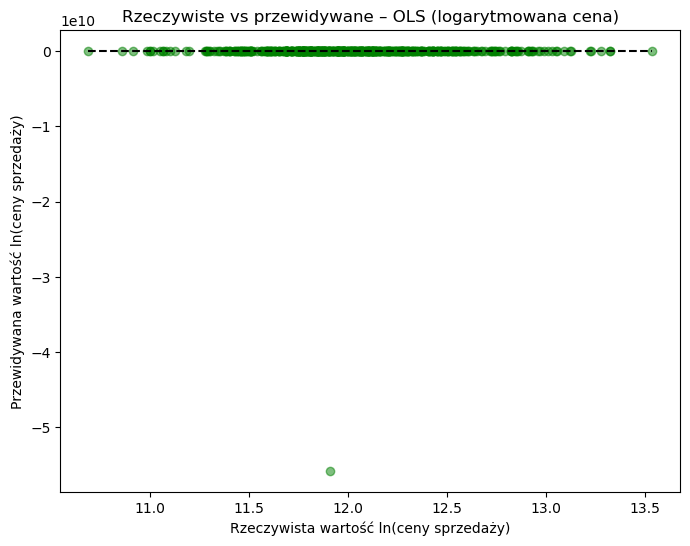

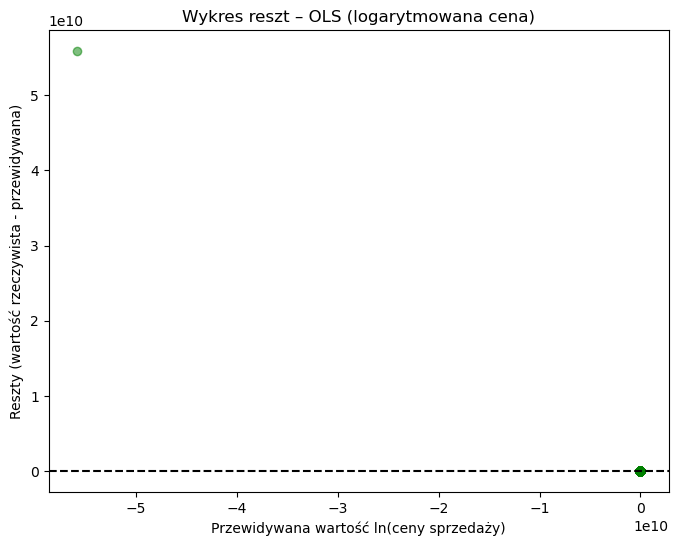

In [37]:
# Wykres 3: Rzeczywiste vs. przewidywane – OLS (logarytmowana cena)
plt.figure(figsize=(8,6))
plt.scatter(y_test_log, y_pred_log, color='green', alpha=0.5)
plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], '--', color='black')
plt.title('Rzeczywiste vs przewidywane – OLS (logarytmowana cena)')
plt.xlabel('Rzeczywista wartość ln(ceny sprzedaży)')
plt.ylabel('Przewidywana wartość ln(ceny sprzedaży)')
plt.show()

# Wykres 4: Rozkład reszt – OLS (logarytmowana cena)
plt.figure(figsize=(8,6))
residuals_log = y_test_log - y_pred_log
plt.scatter(y_pred_log, residuals_log, color='green', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Wykres reszt – OLS (logarytmowana cena)')
plt.xlabel('Przewidywana wartość ln(ceny sprzedaży)')
plt.ylabel('Reszty (wartość rzeczywista - przewidywana)')
plt.show()

In [44]:

# Alpha dla Ridge
alpha_values = np.logspace(-4, 2, 20) 

ridge = Ridge()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(
    ridge,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Najlepszy model i jego alfa
print("Najlepsze alpha:", grid_search.best_params_['alpha'])
best_ridge = grid_search.best_estimator_


y_pred_train = best_ridge.predict(X_train)
y_pred_test = best_ridge.predict(X_test)


r2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"R² (train): {r2_train:.4f}")
print(f"RMSE (train): {rmse_train:.2f}")
print(f"R² (test): {r2_test:.4f}")
print(f"RMSE (test): {rmse_test:.2f}")

Najlepsze alpha: 11.288378916846883
R² (train): 0.9215
RMSE (train): 21644.44
R² (test): 0.9062
RMSE (test): 27499.84


C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


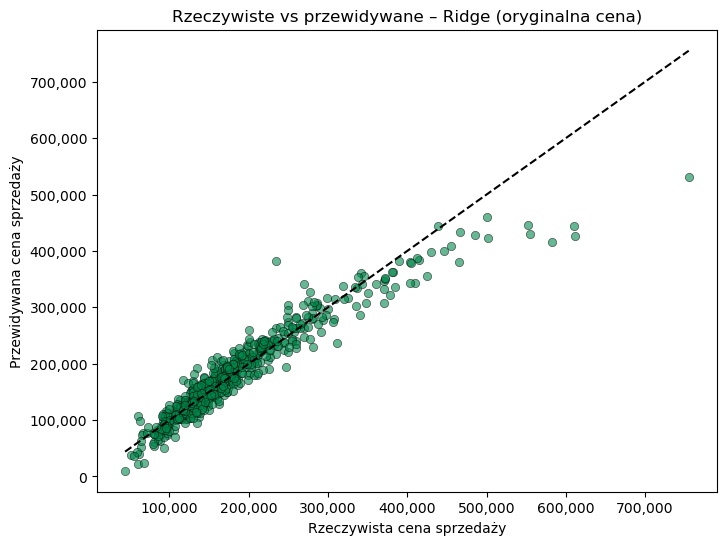

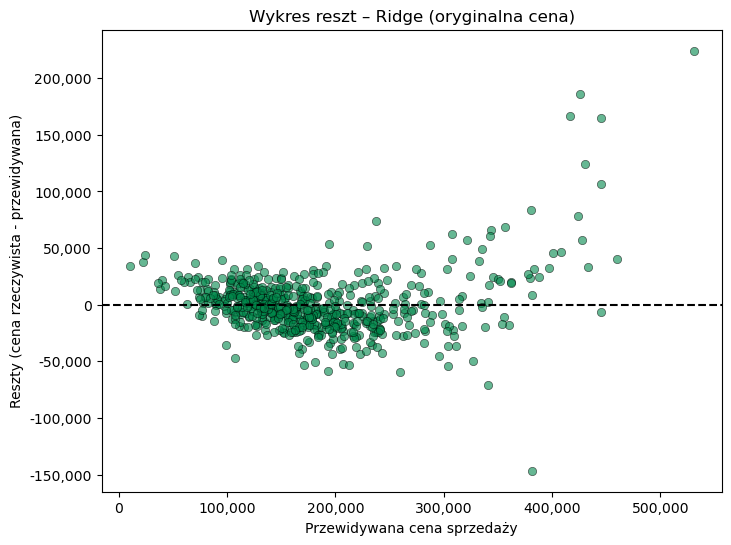

In [45]:
folder = "Praca inżynierska Charts"
os.makedirs(folder, exist_ok=True)

# Przygotowanie 3 wykresów: histogram, boxplot, KDE (krzywa gęstości)

# Styl wykresów
plt.style.use('default')
green_color = '#00884B'

# Wykres 5: Rzeczywiste vs. przewidywane – Ridge (oryginalna cena)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6,color=green_color, edgecolor='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.title('Rzeczywiste vs przewidywane – Ridge (oryginalna cena)')
plt.xlabel('Rzeczywista cena sprzedaży')
plt.ylabel('Przewidywana cena sprzedaży')
plt.savefig(os.path.join(folder, "5_4_5_SalePriceActualVsPridiction.png"), dpi=300, bbox_inches='tight')
plt.show()

# Wykres 6: Rozkład reszt – Ridge (oryginalna cena)
plt.figure(figsize=(8,6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6,color=green_color, edgecolor='k', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Wykres reszt – Ridge (oryginalna cena)')
plt.xlabel('Przewidywana cena sprzedaży')
plt.ylabel('Reszty (cena rzeczywista - przewidywana)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.savefig(os.path.join(folder, "5_4_6_SalePriceActualVsPridictionErrors.png"), dpi=300, bbox_inches='tight')
plt.show()

In [61]:
alpha_values_log = np.logspace(-4, 2, 20)

ridge_log = Ridge()
param_grid_log = {'alpha': alpha_values_log}
grid_search_log = GridSearchCV(
    ridge_log,
    param_grid_log,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_log.fit(X_train_log, y_train_log)

print("Najlepsze alpha (log):", grid_search_log.best_params_['alpha'])
best_ridge_log = grid_search_log.best_estimator_


y_pred_train_log = best_ridge_log.predict(X_train_log)
y_pred_test_log = best_ridge_log.predict(X_test_log)


r2_train_log = r2_score(y_train_log, y_pred_train_log)
rmse_train_log = mean_squared_error(y_train_log, y_pred_train_log, squared=False)

r2_test_log = r2_score(y_test_log, y_pred_test_log)
rmse_test_log = mean_squared_error(y_test_log, y_pred_test_log, squared=False)


print(f"R² (train): {r2_train_log:.4f}")
print(f"RMSE (train): {rmse_train_log:.4f}")
print(f"R² (test): {r2_test_log:.4f}")
print(f"RMSE (test): {rmse_test_log:.4f}")

Najlepsze alpha (log): 11.288378916846883
R² (train): 0.9272
RMSE (train): 0.1089
R² (test): 0.9476
RMSE (test): 0.0971


C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


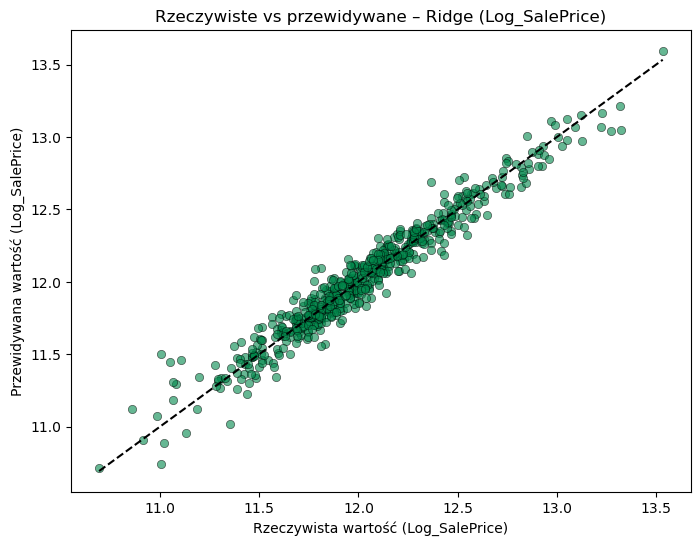

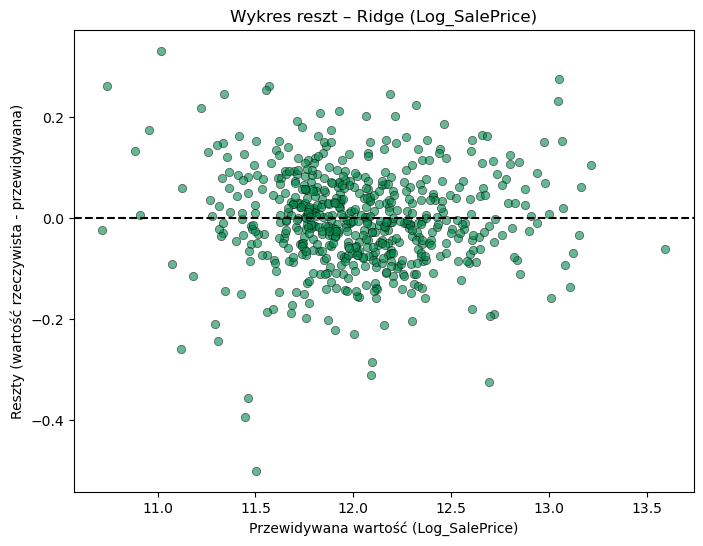

In [47]:
# Wykres 7: Rzeczywiste vs. przewidywane – Ridge (logarytmowana cena)
plt.figure(figsize=(8,6))
plt.scatter(y_test_log, y_pred_test_log, alpha=0.6, color=green_color, edgecolor='k', linewidth=0.5)
plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], '--', color='black')
plt.title('Rzeczywiste vs przewidywane – Ridge (Log_SalePrice)')
plt.xlabel('Rzeczywista wartość (Log_SalePrice)')
plt.ylabel('Przewidywana wartość (Log_SalePrice)')
plt.savefig(os.path.join(folder, "5_4_7_LogSalePriceActualVsPrediction.png"), dpi=300, bbox_inches='tight')
plt.show()

# Wykres 8: Rozkład reszt – Ridge (logarytmowana cena)
residuals_log = y_test_log - y_pred_test_log
plt.figure(figsize=(8,6))
plt.scatter(y_pred_test_log, residuals_log, alpha=0.6, color=green_color, edgecolor='k', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Wykres reszt – Ridge (Log_SalePrice)')
plt.xlabel('Przewidywana wartość (Log_SalePrice)')
plt.ylabel('Reszty (wartość rzeczywista - przewidywana)')
plt.savefig(os.path.join(folder, "5_4_8_LogSalePriceResiduals.png"), dpi=300, bbox_inches='tight')
plt.show()

In [48]:
alpha_values_lasso = np.logspace(-4, 2, 20)

lasso = Lasso(max_iter=10000)
param_grid_lasso = {'alpha': alpha_values_lasso}

grid_search_lasso = GridSearchCV(
    lasso,
    param_grid_lasso,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_lasso.fit(X_train, y_train)

print("Najlepsze alpha (Lasso):", grid_search_lasso.best_params_['alpha'])
best_lasso = grid_search_lasso.best_estimator_

y_pred_train = best_lasso.predict(X_train)
y_pred_test = best_lasso.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)


print(f"R² (train): {r2_train:.4f}")
print(f"RMSE (train): {rmse_train:.2f}")
print(f"R² (test): {r2_test:.4f}")
print(f"RMSE (test): {rmse_test:.2f}")


Najlepsze alpha (Lasso): 23.357214690901213
R² (train): 0.9228
RMSE (train): 21460.91
R² (test): 0.9061
RMSE (test): 27514.86


C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
# Liczba cech i niezerowych współczynników
coef = pd.Series(best_lasso.coef_, index=X_train.columns)
non_zero_coef = coef[coef != 0]

coef_summary = {
    "alpha": best_lasso.alpha,
    "total_features": X_train.shape[1],
    "non_zero_features": non_zero_coef.shape[0],
    "zeroed_features": X_train.shape[1] - non_zero_coef.shape[0],
    "r2_train": r2_train,
    "rmse_train": rmse_train,
    "r2_test": r2_test,
    "rmse_test": rmse_test
}

non_zero_coef = non_zero_coef.sort_values(ascending=False)

coef_summary

{'alpha': 23.357214690901213,
 'total_features': 199,
 'non_zero_features': 140,
 'zeroed_features': 59,
 'r2_train': 0.9227966064441835,
 'rmse_train': 21460.91280733823,
 'r2_test': 0.906064347292672,
 'rmse_test': 27514.860644466244}

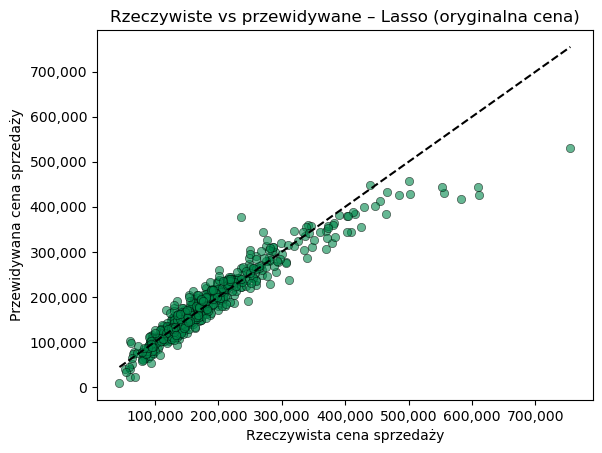

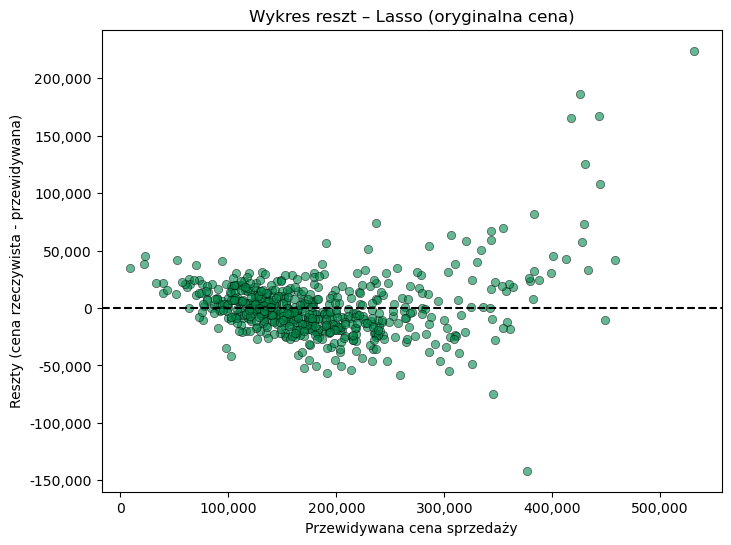

In [54]:
# Wykres 9
plt.scatter(y_test, y_pred_test, alpha=0.6, color=green_color, edgecolor='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.title('Rzeczywiste vs przewidywane – Lasso (oryginalna cena)')
plt.xlabel('Rzeczywista cena sprzedaży')
plt.ylabel('Przewidywana cena sprzedaży')
plt.savefig(os.path.join(folder, "5_4_10_SalePriceActualVsPrediction.png"), dpi=300, bbox_inches='tight')
plt.show()

# Wykres 10: Rozkład reszt – Lasso (oryginalna cena)
residuals_lasso = y_test - y_pred_test
plt.figure(figsize=(8,6))
plt.scatter(y_pred_test, residuals_lasso, alpha=0.6, color=green_color, edgecolor='k', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Wykres reszt – Lasso (oryginalna cena)')
plt.xlabel('Przewidywana cena sprzedaży')
plt.ylabel('Reszty (cena rzeczywista - przewidywana)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
plt.savefig(os.path.join(folder, "5_4_11_SalePriceResiduals.png"), dpi=300, bbox_inches='tight')
plt.show()


In [55]:
alpha_values_lasso_log = np.logspace(-4, 2, 20)

lasso_log = Lasso(max_iter=10000)
param_grid_log = {'alpha': alpha_values_lasso_log}

grid_search_lasso_log = GridSearchCV(
    lasso_log,
    param_grid_log,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_lasso_log.fit(X_train_log, y_train_log)

print("Najlepsze alpha (Lasso log):", grid_search_lasso_log.best_params_['alpha'])
best_lasso_log = grid_search_lasso_log.best_estimator_

y_pred_train_log = best_lasso_log.predict(X_train_log)
y_pred_test_log = best_lasso_log.predict(X_test_log)

r2_train_log = r2_score(y_train_log, y_pred_train_log)
rmse_train_log = mean_squared_error(y_train_log, y_pred_train_log, squared=False)

r2_test_log = r2_score(y_test_log, y_pred_test_log)
rmse_test_log = mean_squared_error(y_test_log, y_pred_test_log, squared=False)

print(f"R² (train): {r2_train_log:.4f}")
print(f"RMSE (train): {rmse_train_log:.4f}")
print(f"R² (test): {r2_test_log:.4f}")
print(f"RMSE (test): {rmse_test_log:.4f}")

Najlepsze alpha (Lasso log): 0.00020691380811147902
R² (train): 0.9267
RMSE (train): 0.1093
R² (test): 0.9475
RMSE (test): 0.0971


C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
coef_log = pd.Series(best_lasso_log.coef_, index=X_train_log.columns)
non_zero_coef_log = coef_log[coef_log != 0]

# Staty modelu
lasso_log_stats = {
    "alpha": best_lasso_log.alpha,
    "total_features": X_train_log.shape[1],
    "non_zero_features": non_zero_coef_log.shape[0],
    "zeroed_features": X_train_log.shape[1] - non_zero_coef_log.shape[0],
    "r2_train": r2_score(y_train_log, best_lasso_log.predict(X_train_log)),
    "rmse_train": mean_squared_error(y_train_log, best_lasso_log.predict(X_train_log), squared=False),
    "r2_test": r2_score(y_test_log, best_lasso_log.predict(X_test_log)),
    "rmse_test": mean_squared_error(y_test_log, best_lasso_log.predict(X_test_log), squared=False)
}

lasso_log_stats

C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Program Files\Anaconda\envs\PracaInz\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'alpha': 0.00020691380811147902,
 'total_features': 199,
 'non_zero_features': 120,
 'zeroed_features': 79,
 'r2_train': 0.9266657016040527,
 'rmse_train': 0.10929196230623507,
 'r2_test': 0.9474939588391924,
 'rmse_test': 0.09711485500066087}

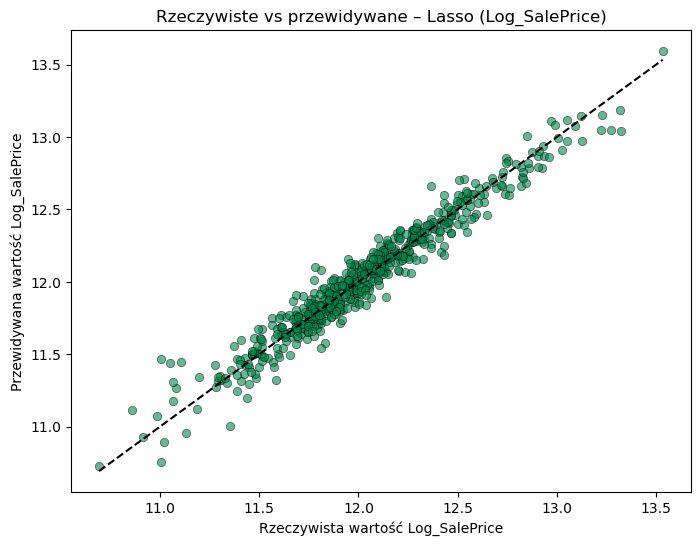

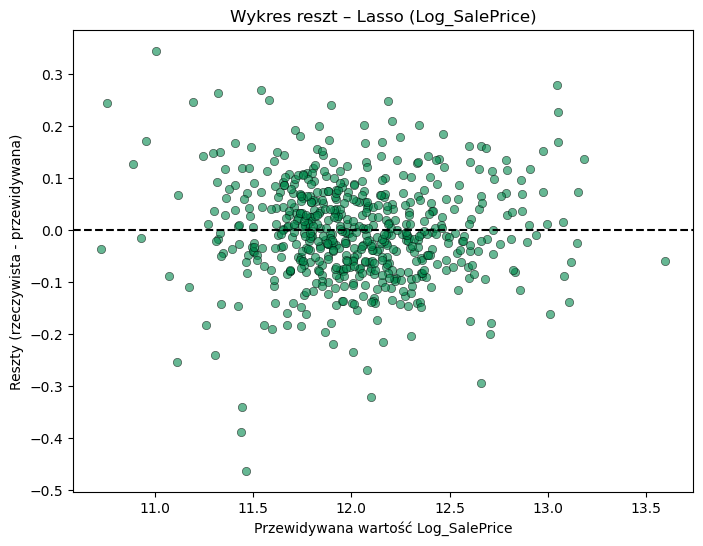

In [60]:
# Wykres 11
plt.figure(figsize=(8,6))
plt.scatter(y_test_log, y_pred_test_log, color=green_color, alpha=0.6, edgecolor='k', linewidth=0.5)
plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], '--', color='black')
plt.title('Rzeczywiste vs przewidywane – Lasso (Log_SalePrice)')
plt.xlabel('Rzeczywista wartość Log_SalePrice')
plt.ylabel('Przewidywana wartość Log_SalePrice')
plt.savefig(os.path.join(folder, "5_4_12_LogSalePriceActualVsPrediction.png"), dpi=300, bbox_inches='tight')
plt.show()

# Wykres 12
residuals_log = y_test_log - y_pred_test_log
plt.figure(figsize=(8,6))
plt.scatter(y_pred_test_log, residuals_log, color=green_color, alpha=0.6, edgecolor='k', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Wykres reszt – Lasso (Log_SalePrice)')
plt.xlabel('Przewidywana wartość Log_SalePrice')
plt.ylabel('Reszty (rzeczywista - przewidywana)')
plt.savefig(os.path.join(folder, "5_4_13_LogSalePriceResiduals.png"), dpi=300, bbox_inches='tight')
plt.show()

In [65]:
pd.set_option('display.float_format', '{:,.4f}'.format)
np.set_printoptions(suppress=True)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

models = {
    "Ridge (SalePrice)":    {"model": best_ridge,        "X": X_test,      "y": y_test,     "p": 199},
    "Lasso (SalePrice)":    {"model": best_lasso,        "X": X_test,      "y": y_test,     "p": 140},
    "Ridge (Log_SalePrice)": {"model": best_ridge_log,    "X": X_test_log,  "y": y_test_log, "p": 199},
    "Lasso (Log_SalePrice)": {"model": best_lasso_log,    "X": X_test_log,  "y": y_test_log, "p": 120},
}

results = []

for name, info in models.items():
    mdl = info["model"]
    X_t, y_t, p = info["X"], info["y"], info["p"]
    n = len(y_t)

    y_pred = mdl.predict(X_t)
    
    mae  = mean_absolute_error(y_t, y_pred)
    rmse = np.sqrt(mean_squared_error(y_t, y_pred))
    mape = mean_absolute_percentage_error(y_t, y_pred)
    r2   = r2_score(y_t, y_pred)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    residuals = y_t - y_pred
    sse = np.sum(residuals ** 2)
    rse = np.sqrt(sse / (n - p - 1))
    
    results.append({
        "Model": name,
        "R²": r2,
        "Adjusted R²": r2_adj,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "RSE": rse
    })

df_metrics = pd.DataFrame(results).set_index("Model")
print(df_metrics.to_string())



                          R²  Adjusted R²        RMSE         MAE  MAPE (%)         RSE
Model                                                                                  
Ridge (SalePrice)     0.9062       0.8578 27,499.8370 17,745.6669   10.0848 33,883.2668
Lasso (SalePrice)     0.9061       0.8765 27,514.8606 17,742.2316   10.0523 31,574.4737
Ridge (Log_SalePrice) 0.9476       0.9205      0.0971      0.0731    0.6105      0.1196
Lasso (Log_SalePrice) 0.9475       0.9339      0.0971      0.0740    0.6179      0.1090


In [67]:
y_pred_log = best_ridge_log.predict(X_test_log) 
y_pred_orig = np.exp(y_pred_log)

rmse_back = np.sqrt(mean_squared_error(y_test, y_pred_orig))
mae_back  = mean_absolute_error(y_test, y_pred_orig)
mape_back = np.mean(np.abs((y_test - y_pred_orig)/y_test))*100

In [69]:
rmse_back


19655.914035868467

In [70]:
mae_back


13281.007304725475

In [71]:
mape_back

7.375513924181377

In [74]:
y_pred_log = best_lasso_log.predict(X_test_log)
y_pred_orig = np.exp(y_pred_log)

rmse_back = np.sqrt(mean_squared_error(y_test, y_pred_orig))
mae_back  = mean_absolute_error(y_test, y_pred_orig)
mape_back = np.mean(np.abs((y_test - y_pred_orig)/y_test))*100

In [75]:
rmse_back

19860.713327597583

In [76]:
mae_back

13461.63931170456

In [77]:
mape_back

7.452154059466697

In [78]:
# Powród z logarytmu na wartości w skali klasycznej, żeby móc porówanć modele
models_back = {
    "Ridge (Log→orig)": {"model": best_ridge_log, "p": 199},
    "Lasso (Log→orig)": {"model": best_lasso_log, "p": 120},
}

results_back = []
n = len(y_test)

for name, info in models_back.items():
    mdl = info["model"]
    p = info["p"]
    
    # back‑transformacja
    y_pred_log = mdl.predict(X_test_log)
    y_pred_orig = np.exp(y_pred_log)
    
    #  SSE i RSE
    residuals = y_test - y_pred_orig
    sse = np.sum(residuals ** 2)
    rse_back = np.sqrt(sse / (n - p - 1))
    
    results_back.append({
        "Model": name,
        "RSE_back (USD)": rse_back
    })

df_back_rse = pd.DataFrame(results_back).set_index("Model")
print(df_back_rse.to_string())

                  RSE_back (USD)
Model                           
Ridge (Log→orig)     24,218.5646
Lasso (Log→orig)     22,295.4978


In [80]:
# Predykcje modeli w skali logarytmicznej
y_pred_log_ridge = best_ridge_log.predict(X_test_log)
y_pred_log_lasso = best_lasso_log.predict(X_test_log)

# Back‑transformacja: exp → predykcje w USD
ridge_back = np.exp(y_pred_log_ridge)
lasso_back = np.exp(y_pred_log_lasso)

from scipy.stats import wilcoxon

# Różnica absolutnych błędów
diff = np.abs(y_test - ridge_back) - np.abs(y_test - lasso_back)

# Test Wilcoxona na istotność różnicy w błędach
stat, p = wilcoxon(diff)
print(f"Wilcoxon statistic = {stat:.4f}, p‑value = {p:.4f}")

Wilcoxon statistic = 78583.0000, p‑value = 0.0706


In [81]:
models_log = {
    'Ridge (Log_SalePrice)': {'model': best_ridge_log, 'X': X_test_log, 'y': y_test_log, 'p': 199},
    'Lasso (Log_SalePrice)': {'model': best_lasso_log, 'X': X_test_log, 'y': y_test_log, 'p': 120},
}

n = len(y_test_log)
results_ic = []

for name, info in models_log.items():
    mdl = info['model']
    X_t, y_t, p = info['X'], info['y'], info['p']
    y_pred = mdl.predict(X_t)
    
    # SSE w skali log
    sse_log = np.sum((y_t - y_pred)**2)
    
    # AIC i BIC
    aic = n * np.log(sse_log / n) + 2 * p
    bic = n * np.log(sse_log / n) + p * np.log(n)
    
    results_ic.append({'Model': name, 'AIC': aic, 'BIC': bic})

df_ic = pd.DataFrame(results_ic).set_index('Model')
print(df_ic.to_string())

                              AIC         BIC
Model                                        
Ridge (Log_SalePrice) -2,335.5669 -1,465.2763
Lasso (Log_SalePrice) -2,492.9410 -1,968.1426


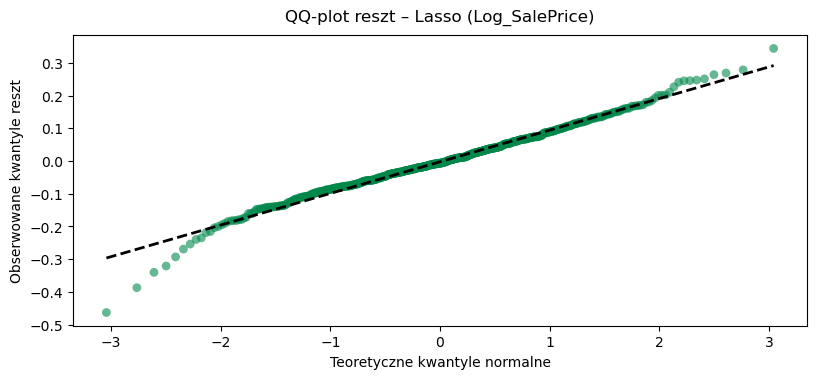

In [98]:
# Wykres reszt dla najlepszego modelu

a4_width, a4_height = 8.27, 11.69
bottom_third_height = a4_height / 3  

y_pred_lasso_log = best_lasso_log.predict(X_test_log)
resid_lasso_log = y_test_log - y_pred_lasso_log

osm, osr = stats.probplot(resid_lasso_log, dist="norm", fit=False)
slope, intercept = stats.probplot(resid_lasso_log, dist="norm", fit=True)[1][:2]

plt.figure(figsize=(a4_width, bottom_third_height))
plt.scatter(osm, osr, color=green_color, edgecolors='none', alpha=0.6, s=40)
plt.plot(osm, intercept + slope * osm, color='black', linestyle='--', linewidth=2)
plt.title('QQ‑plot reszt – Lasso (Log_SalePrice)', pad=10)
plt.xlabel('Teoretyczne kwantyle normalne')
plt.ylabel('Obserwowane kwantyle reszt')
plt.tight_layout()
# Zapis wykresu
plt.savefig(os.path.join(folder, "6_1_LassoQQ.png"), dpi=300, bbox_inches='tight')
plt.show()


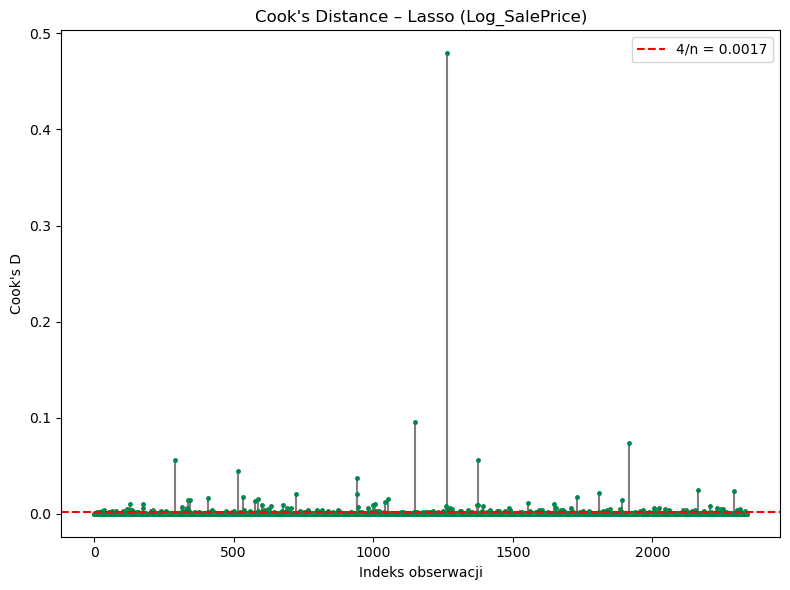

In [108]:
# Wybór cech niezerowych modelu Lasso Log - Liczę odległości Cooka dla modelu (nie umieszczam tego w pracy, dodatkowe)
nonzero_mask = best_lasso_log.coef_ != 0
X_sel = X_train_log.loc[:, nonzero_mask]

# Dodanie stałej i dopasowanie modelu
X_sel_sm = sm.add_constant(X_sel.astype(float))
model_ols_sel = sm.OLS(y_train_log, X_sel_sm).fit()

# Obliczenie odległości Cooka
influence = OLSInfluence(model_ols_sel)
cooks_d = influence.cooks_distance[0]
n = len(cooks_d)
threshold = 4 / n

plt.figure(figsize=(8, 6))
markerline, stemlines, baseline = plt.stem(
    np.arange(n), cooks_d,
    markerfmt='.', linefmt='grey', basefmt=' '
)
plt.setp(markerline, 'color', green_color, 'markersize', 5)
plt.axhline(threshold, color='red', linestyle='--', label=f'4/n = {threshold:.4f}')
plt.title("Cook's Distance – Lasso (Log_SalePrice)")
plt.xlabel('Indeks obserwacji')
plt.ylabel("Cook's D")
plt.legend()
plt.tight_layout()
plt.show()


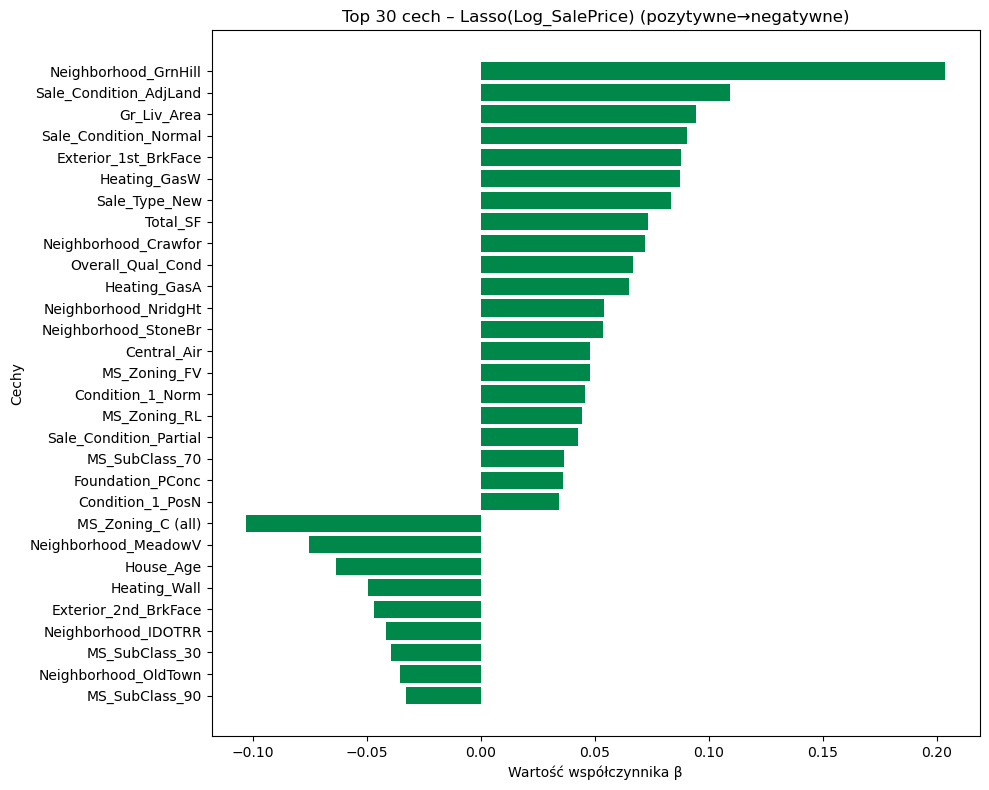

,Feature,β (signed),|β|
0,Neighborhood_GrnHill,0.2036,0.2036
1,Sale_Condition_AdjLand,0.1092,0.1092
2,Gr_Liv_Area,0.0943,0.0943
3,Sale_Condition_Normal,0.0905,0.0905
4,Exterior_1st_BrkFace,0.0878,0.0878
5,Heating_GasW,0.0873,0.0873
6,Sale_Type_New,0.0835,0.0835
7,Total_SF,0.0734,0.0734
8,Neighborhood_Crawfor,0.0722,0.0722
9,Overall_Qual_Cond,0.0667,0.0667


In [109]:
#  TOP 30 cech według wartości bezwzględnej współczynnika beta
lasso_coefs = pd.Series(best_lasso_log.coef_, index=X_train_log.columns)

top30 = lasso_coefs.abs().nlargest(30)
top30_df = pd.DataFrame({
    'Feature': top30.index,
    'β (signed)': lasso_coefs[top30.index].values,
    '|β|': top30.values
})

# Dzielę na dodatnie i ujemne
pos_df = top30_df[top30_df['β (signed)'] > 0].copy()
neg_df = top30_df[top30_df['β (signed)'] < 0].copy()

# Kolejność w obrębie grup
pos_df = pos_df.sort_values('|β|', ascending=False)
neg_df = neg_df.sort_values('|β|', ascending=False)

# Łączenie: dodatnie najpierw, potem ujemne
sorted_df = pd.concat([pos_df, neg_df], axis=0).reset_index(drop=True)

# Wykres barplot posortowany
plt.figure(figsize=(10, 8))
plt.barh(sorted_df['Feature'][::-1], sorted_df['β (signed)'][::-1], color=green_color)
plt.title('Top 30 cech – Lasso(Log_SalePrice) (pozytywne→negatywne)')
plt.xlabel('Wartość współczynnika β')
plt.ylabel('Cechy')
plt.tight_layout()
plt.show()

sorted_df